In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import mlflow
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature

from sd_vae.ae import VAE
from trainers import EarlyStopping
from trainers.first_stage_trainer import CLEAR_VAEFirstStageTrainer

from modules.loss import SupCon, SNN

import data_utils.styled_mnist.corruptions as corruptions
from data_utils.styled_mnist.data_utils import StyledMNISTGenerator, StyledMNIST

%load_ext autoreload
%autoreload 2

In [3]:
mnist = MNIST("./data", train=True, download=False)

In [4]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)
dataset = StyledMNIST(
    generator, 
    transforms.Compose([
        transforms.ToTensor(), 
        lambda img: img / 255.0,
    ])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])

Generating dataset: 100%|██████████| 60000/60000 [00:13<00:00, 4376.47item/s]


In [5]:
train_loader = DataLoader(train, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [147]:
params = {
    "lr": 5e-4,
    "optimizer": "Adam",
    "batch_size": 512,
    "beta": 1 / 8,
    "gamma": 100,
    "z_channels": 8,
    "contrastive_module": "SNN",
    "temperature": 0.1,
}

input_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
output_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

vae = VAE(
    channels=32,
    channel_multipliers=[1, 2, 4],
    n_resnet_blocks=1,
    x_channels=1,
    z_channels=params["z_channels"],
    norm_channels=32,
    n_heads=4,
).cuda()

trainer = CLEAR_VAEFirstStageTrainer(
    contrastive_criterions={
        "content": eval(params["contrastive_module"])(temperature=params["temperature"]),
        "style": eval(params["contrastive_module"])(temperature=params["temperature"]),
    },
    model=vae,
    early_stopping=EarlyStopping(patience=8),
    verbose_period=2,
    device="cuda",
    model_signature=signature,
    args={
        "beta": params["beta"],
        "gamma": params["gamma"],
        "vae_lr": params["lr"],
    },
)

In [148]:
mlflow.set_tracking_uri("./mlruns")
mlflow.set_experiment("test")
with mlflow.start_run():
    mlflow.log_params(params)
    trainer.fit(epochs=51, train_loader=train_loader, valid_loader=valid_loader)

100%|██████████| 79/79 [00:01<00:00, 72.29batch/s]


epoch 0/val_rec: 47.2291
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 71.68batch/s]


epoch 2/val_rec: 29.6126
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 71.23batch/s]


epoch 4/val_rec: 24.0584
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 70.62batch/s]


epoch 6/val_rec: 19.9040
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 71.00batch/s]


epoch 8/val_rec: 16.5659
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 70.46batch/s]


epoch 10/val_rec: 15.0562
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 70.81batch/s]


epoch 12/val_rec: 13.7319
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 68.36batch/s]


epoch 14/val_rec: 12.3292
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 69.40batch/s]


epoch 16/val_rec: 12.1015
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 70.56batch/s]


epoch 18/val_rec: 11.4526
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 69.21batch/s]


epoch 20/val_rec: 11.2840
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 69.49batch/s]


epoch 22/val_rec: 10.7162
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 69.53batch/s]


epoch 24/val_rec: 12.5859


100%|██████████| 79/79 [00:01<00:00, 69.57batch/s]


epoch 26/val_rec: 10.5482
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 70.21batch/s]


epoch 28/val_rec: 10.6014


100%|██████████| 79/79 [00:01<00:00, 69.87batch/s]


epoch 30/val_rec: 10.5937


100%|██████████| 79/79 [00:01<00:00, 70.33batch/s]


epoch 32/val_rec: 10.3194
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 69.72batch/s]


epoch 34/val_rec: 9.9160
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 69.19batch/s]


epoch 36/val_rec: 10.4988


100%|██████████| 79/79 [00:01<00:00, 69.90batch/s]


epoch 38/val_rec: 9.9341


100%|██████████| 79/79 [00:01<00:00, 69.76batch/s]


epoch 40/val_rec: 9.3760
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 69.36batch/s]


epoch 42/val_rec: 9.5481


100%|██████████| 79/79 [00:01<00:00, 68.28batch/s]


epoch 44/val_rec: 9.2854


100%|██████████| 79/79 [00:01<00:00, 69.39batch/s]


epoch 46/val_rec: 10.0588


100%|██████████| 79/79 [00:01<00:00, 70.37batch/s]


epoch 48/val_rec: 9.5339


100%|██████████| 79/79 [00:01<00:00, 69.60batch/s]


epoch 50/val_rec: 9.2834
[INFO]: log best model


In [6]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

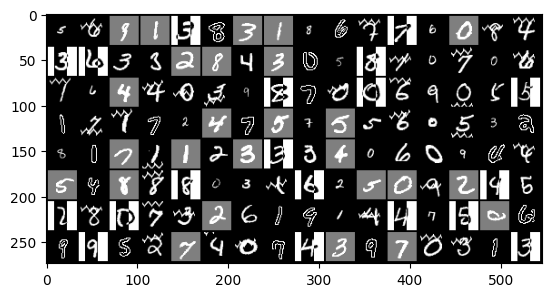

In [7]:
batch = next(iter(test_loader))
x, y = batch['image'].to("cuda"), batch['label'].to("cuda")
plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))

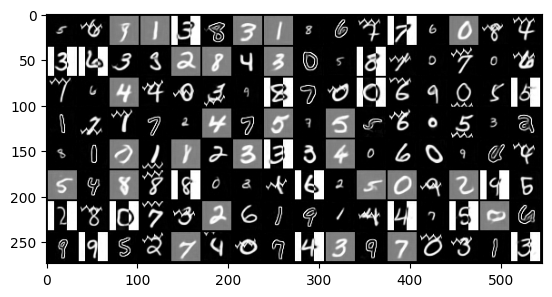

In [8]:
x = next(iter(test_loader))['image'].to("cuda")
best_model = mlflow.pytorch.load_model('runs:/c7aef93fd9d14a9e8807df0e631e9c2a/best_model')
with torch.no_grad():
    best_model.eval()
    xhat, posterior = best_model(x)
    plt.imshow(make_grid(xhat, nrow=16).cpu().permute(1,2,0))

torch.Size([128, 8, 8, 8])


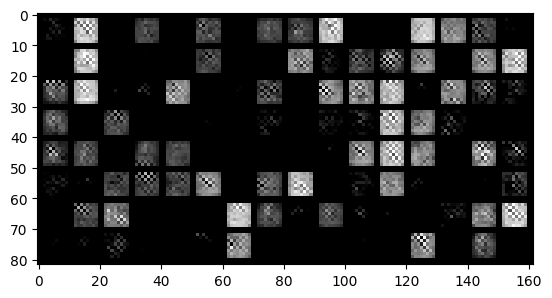

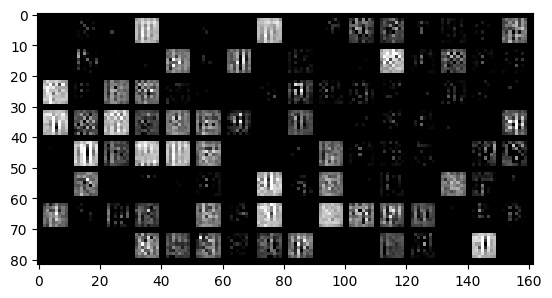

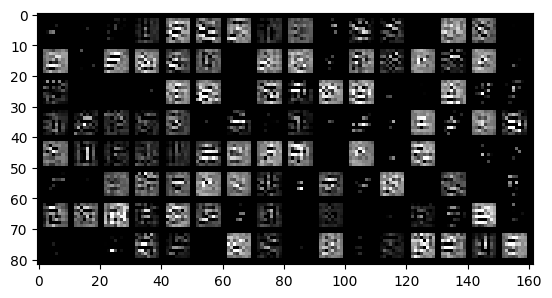

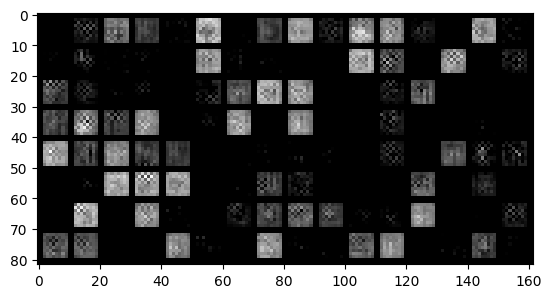

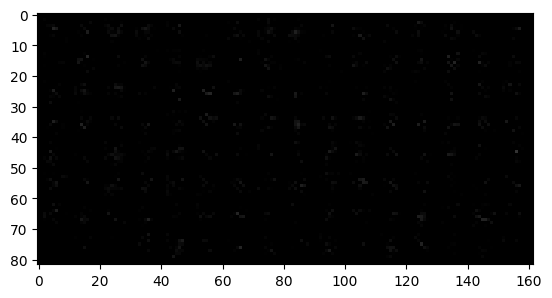

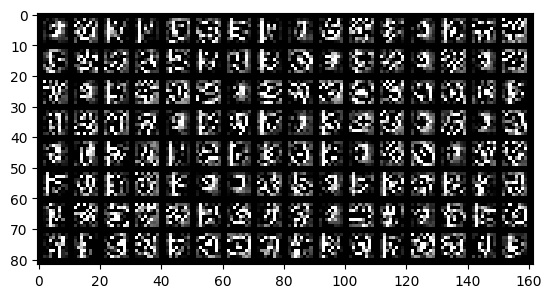

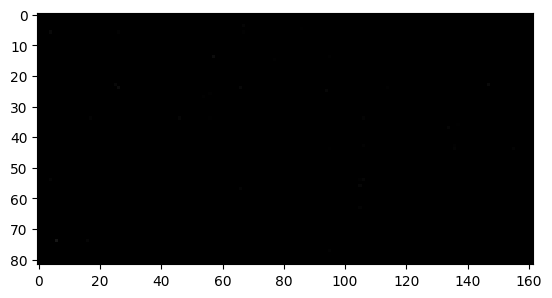

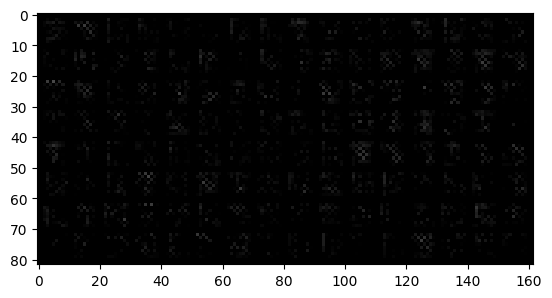

In [9]:
mu = posterior.mu
print(mu.shape)
for i in range(mu.shape[1]):
    plt.imshow(make_grid(mu[:,i][:,None,:,:], nrow=16).cpu().permute(1,2,0))
    plt.show()

In [10]:
from tqdm import tqdm

In [11]:
z_cs = []
z_ss = []
labels = []
styles = []

with torch.no_grad():
    best_model.eval()
    for batch in tqdm(test_loader):
        x = batch['image'].cuda()
        _, posterior = best_model(x)
        z_c, z_s = posterior.sample().chunk(2, dim=1)
        z_cs.append(z_c.cpu())
        z_ss.append(z_s.cpu())
        labels.append(batch['label'])
        styles.append(batch['style'])

z_cs = torch.cat(z_cs, dim=0)
z_ss = torch.cat(z_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:01<00:00, 61.56it/s]


In [12]:
from sklearn.manifold import TSNE

In [24]:
tsne = TSNE(n_components=2, init='pca')
z_2d = tsne.fit_transform(z_cs.view(z_cs.shape[0], -1).numpy())

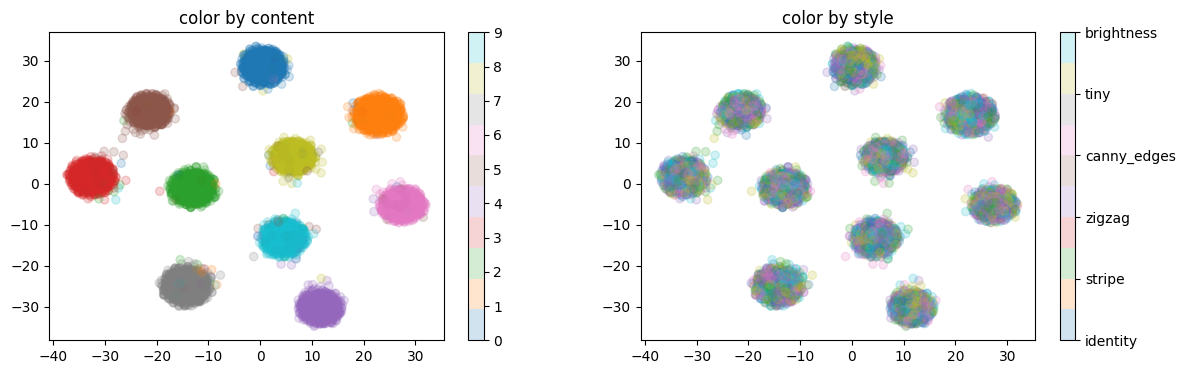

In [26]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edges', 'tiny', 'brightness']
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs0 = axs[0].scatter(z_2d[:, 0], z_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.2)
cbar = fig.colorbar(axs0, ax=axs[0])
axs[0].set_title('color by content')
axs1 = axs[1].scatter(z_2d[:, 0], z_2d[:, 1], c=styles.numpy(), cmap='tab10', alpha=0.2)
axs[1].set_title('color by style')
cbar = fig.colorbar(axs1, ax=axs[1])
cbar.set_ticks(np.arange(len(style_labels)))
cbar.set_ticklabels(style_labels)
plt.show()

In [27]:
tsne = TSNE(n_components=2, init='pca')
z_2d = tsne.fit_transform(z_ss.view(z_ss.shape[0], -1).numpy())

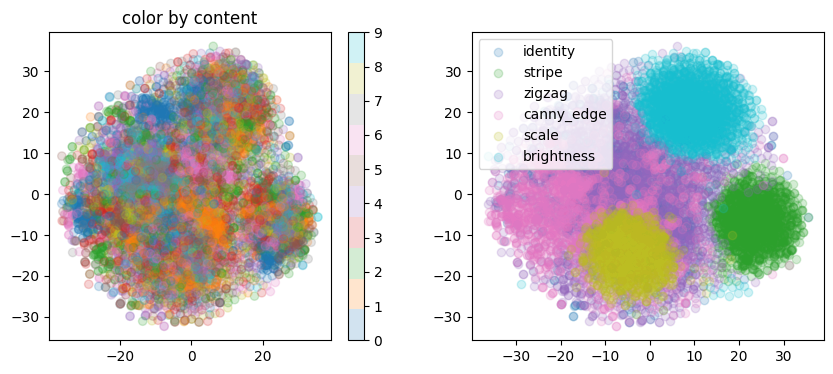

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs0 = axs[0].scatter(z_2d[:, 0], z_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.2)
cbar = fig.colorbar(axs0, ax=axs[0])
axs[0].set_title('color by content')

style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale','brightness']
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    axs[1].scatter(z_2d[i,0], z_2d[i,1], alpha=0.2, c=colors[g], label=style_labels[g])
axs[1].legend()
plt.show()

In [19]:
z_c, z_s = mu.chunk(2, dim=1)
z_s = torch.cat([z_s[1:], z_s[:1]], dim=0)
z = torch.cat([z_c, z_s], dim=1).contiguous()


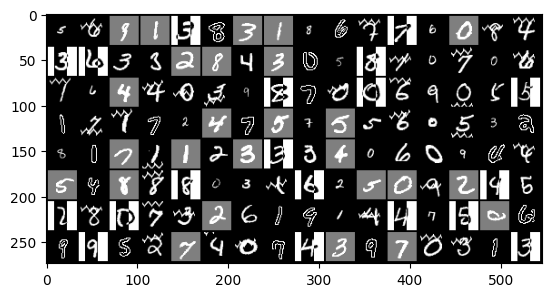

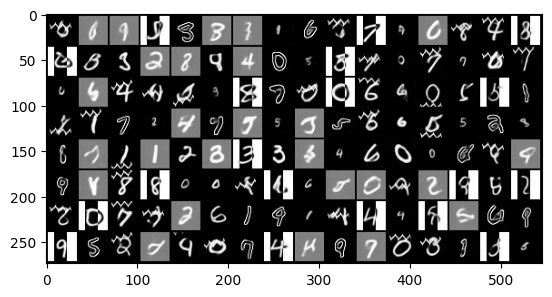

In [20]:
x = next(iter(test_loader))['image'].to("cuda")
plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))
plt.show()
with torch.no_grad():
    best_model.eval()
    z = z * 0.18215
    xhat = best_model.decoder(z)
    plt.imshow(make_grid(xhat, nrow=16).cpu().permute(1,2,0))

interestingly, the current channel-wise disentanglement cannot differentiate all styles but only some of them.

In [109]:
import torch.nn as nn

In [112]:
x = torch.ones(2, 3, 8, 8)
nn.AdaptiveAvgPool2d(output_size=1)(x).squeeze()


tensor([[1., 1., 1.],
        [1., 1., 1.]])